In [9]:
import math
import torch
from torch import nn
from d2l import torch as d2l

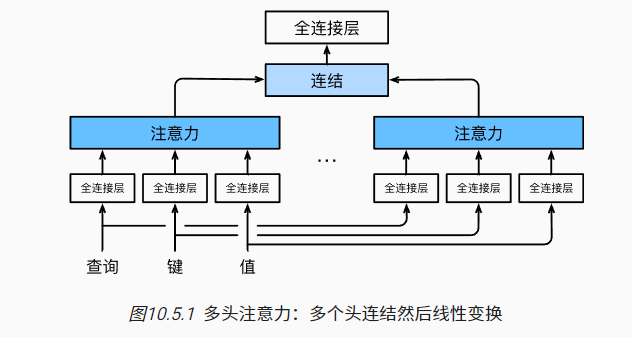

In [10]:
from IPython.display import Image
Image(filename = 'E:\Clancy\Code\动手学深度学习NLP篇\\mutilhandattention.png', width=10, height=10)

In [11]:
#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者"键－值"对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者"键－值"对的个数，num_heads，num_hiddens/num_heads)
    
    # 将原先输入的X的最后一个维度num_hiddens 生维度切分成 num_heads个块
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者"键－值"对的个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者"键－值"对的个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [12]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)

        # 多头注意力中头的个数也就是Attention的个数
        self.num_heads = num_heads

        # 此时选择了学习量更少的缩放点积注意力
        self.attention = d2l.DotProductAttention(dropout)

        # 线性投影到隐藏层长度,统一输入
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        #   -> (batch_size，查询或者"键－值"对的个数，num_hiddens)
        
        # valid_lens　的形状:
        #   -> (batch_size，)或(batch_size，查询的个数)

        # 经过变换后，输出的queries，keys，values　的形状:
        #   -> (batch_size*num_heads，查询或者"键－值"对的个数，num_hiddens/num_heads)

        # 这里的转换运算 只是为了将多次attention所需要的数据 合并在一起，只需要一次投入
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [13]:
num_hiddens = 100
num_heads = 5

attention = MultiHeadAttention(
    num_hiddens, num_hiddens, num_hiddens,num_hiddens, 
    num_heads, 0.5
    )
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [14]:
batch_size = 2
num_queries = 4
num_kvpairs =  6
valid_lens = torch.tensor([3, 2])

X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])